# 1D Oblique Sphere Collisions

Using our knowledge of the conservation of linear momentum, we'll aim to set up an animated example of two objects colliding in 1D.

As always, we need to load in the Python libraries that we need to carry out the plotting, animation and (in this case) solve a set of simultaneous equations.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import matplotlib.patches as patches
#import random
import math
from IPython.display import HTML
#import sys
#!{sys.executable} -m pip install --upgrade Ipython

## Mathematics Recap

For this course, we will restrict ourselves by considering two objects colliding in 1D. 
Each object is associated with a mass and a velocity before they collide.
The behaviour of the objects after the collision is entirely determined by the state of the system before the collision, and several key pieces of maths.

### Conservation of Total Linear Momentum

The **total linear momentum** of the system is a conserved quantity: this means that the total linear momentum of the system before the collision remains the same before and after the collision. 

Linear momentum (commonly denoted with $p$) is the product of the mass of an object ($m$) multiplied by its linear velocity ($v$):

$$
p = mv
$$

If we label the mass of each object in the system as $m_1$ and $m_2$, and the linear velocity of each mass before the collision as $u_1$ and $u_2$, the total linear momentum before the collision is 

$$
p_{\rm{before}} = m_1u_1+m_2u_2.
$$

After the collision, assuming no change in mass of either object, the objective is therefore to identify any unknown velocities. The strategy to find these depends on the type of collision (for example, completely elastic, partially inelastic, or completely inelastic). If the collision is completely inelastic, the two objects will move as one after the collision, and hence there will only be one unknown ($v_{\rm{after}}$. In other cases, each object will be associated with its own velocity, and hence there would be two unknowns, $v_1$ and $v_2$. In cases where we have more unknowns than equations, we require another equation to solve the system.

### Newton's Law of Restitution

Newton's Law of Restitution allows us to relate the velocities of the object before and after a collision through a parameter, $e$, called the "coefficient of restitution":

$$
\frac{v_2 - v_1}{u_1-u_2} = e.
$$

The coefficient $e$ can take any value between $0$ and $1$, depending on the type of collision:
* $e=0$ implies a completely inelastic collision
* $e=1$ implies a completely elastic collision
* $0<e<1$ implies an inelastic collision, and is much more representative of the real world (since in real collisions, some -not all and not no- energy is typically lost).

Consider the situation when $e=0$: from the above equation, we simply cannot relate $u_1$ and $u_2$ to $v_1$ and $v_2$. In the situation where $e=0$, all we know is that $v_2-v_1=0$, which is another way of saying $v_2=v_1$, i.e. both objects *stick together* and travel at the same speed.

In all other situations, Newton's Law of Restitution allows $u_1$ and $u_2$ to relate to post-collision velocities $v_1$ and $v_2$.

### Problem solving strategy

For problems we will encounter, our aim is to describe the system after the collision, based on the initial conditions and knowledge of the type of collision (usually by specifying $e$). This would typically lead to a set of simultaneous equations to solve for $v_1$ and $v_2$ (but will still work in cases where objects stick together after the collision, as we will see).

### How Python solves simultaneous equations

Python solves simultaneous equations in a different way to us. It cannot use row operations (your training tells you what to multiply each row by: Python cannot "think" for itself). Instead it uses matrix operations. 

Consider the equations 

$$
x + 2y = 4\\
3x - 5y = 1
$$

We would likely multiply row 1 by minus three, then add to row two to yield a solution for $y$, then solve for $x$. Python cannot do this. Instead, we can write these in matrix form as 

$$
\begin{pmatrix}
	1 & 2   \\
	3 & -5   
\end{pmatrix}
\begin{pmatrix}
	x    \\
	y    
\end{pmatrix} =    
\begin{pmatrix}
	4    \\
	1    
\end{pmatrix}    
$$

You can verify that multiplying the matrices on the left hand side recovers the original equations in each line.

Writing 

$$
A=
\begin{pmatrix}
	1 & 2   \\
	3 & -5   
\end{pmatrix},~~~~~~~
X=
\begin{pmatrix}
	x    \\
	y    
\end{pmatrix},~~~~~~~
B=
\begin{pmatrix}
	4    \\
	1    
\end{pmatrix}.    
$$

means that 

$$
AX=B,
$$

which is the *matrix form* of these simultaneous equations. The only unknown quantity is $X$, since we already know $A$ and $B$. $A$ is known as the matrix of coefficients.

Python can calculate $X$ by inverting $A$ and multiplying everything by this. This effectively reduces the left hand side to just $X$, and the right hand side is the product of two known matrices:

$$
A^{-1}AX = IX =A^{-1}B,
$$

where $I$ is the identity matrix (and $IX=X$, since multiplication by the identity matrix does not affect any the result).

Python will calculate the inverse of the matrix of coefficients in our system $A^{-1}$, multiply it by the matrix $B$, and return the values we need ($X$).


## Animating Collisions

It would be nice if we could create an animation showing the behaviour of a pair of objects before and after a collision.

We will go through the process of creating an animation for one specific collision, detailing each of the steps. We'll then repeat the operations without explanation for different collisions.

### Completely Inelastic Collision

For the illustrative example, we will consider two objects, A and B. Each has a mass and an initial speed:

In [2]:
#initial velocity (m/s)
u_A = 4.0
u_B = 1.0
# masses (kg)
m_A = 2.0
m_B = 4.0

We should also set up the coefficient of restitution and the step size in time of the simulation. For this first example we will consider a **completely inelastic collision**, i.e. set $e=0$. Remember that from the lectures, we know this should result in the two objects **sticking together and travelling with the same velocity after the collision**.

In [3]:
# The coefficient of restitution:
e = 0
# The time step for the animation (s)
dt = 0.05

The initial position is tricky; the objects are travelling at different speeds, so the collision might take place off-screen if we don't take care. 

Our tactic is to fix the collision to take place at $\left(x=0,y=0\right)$. We know the initial velocity the objects travel at, and they are not accelerating; our first year maths says displacement $s$ is given by the expression $s=ut+1/2at^2$, which reduces to $s=ut$ if $a=0$. 

So our position will behave like $x(t)=u_x t$ before the collision, which will take place at $t=0$. Our neat trick here is to pick a time *before* $t=0$ and see where the ball would be. I fix $t=-1$, and hence $x(t=-1)=-u_x$ as our initial position. 

In [4]:
# Initial positions and velocities.
x0_A = -u_A
x0_B = -u_B
y0_A = 0.0
y0_B = 0.0
vx0_A = u_A 
vx0_B = u_B 

Now that our initial positions are fixed, this will essentially also fix the size of our plotting area. We'll fix the extent of our plot to be twice as big as the largest initial displacement in x, in order to prevent either object beginning off-screen.

In [5]:
lval = (max(abs(x0_A), abs(x0_B)))
extent = 2 * int(math.ceil(lval))

Now we can look to solve the equations we defined earlier. These equations are

1.   Conservation of Total Linear Momentum
2.   Newton's Law of Restitution

Python doesn't care what they are though: it needs the matrix of coefficients $A$, which we can create now, and the matrix $B$ which we will calculate later at the moment of impact in the animation.

In [6]:
# matrix of coeffs (to use to solve simultaneous equations)
A = [[1, -1], [m_B, m_A]]

We know that the collisions will take place at the origin. However, we're moving in time using discrete timesteps; depending on the size of dt, we might not actually hit the origin exactly, but potentially miss it by a small amount.

We'lll model each object as a circle. Another way to detect a collision (without relying on it taking place at the origin) is to check if one of the circles overlaps the other. To do this, we'll make a function to check the distance between the centres of the circles. If the distance is less than the radius of each circle added together, then the circles have overlapped. This is a relatively crude approximation, but it will serve for this demo:

In [7]:
rA, rB = 0.1, 0.1 #set radius
def overlap(x1, x2, r1, r2):
# subroutine to check if circles overlap  
    distSq = (x1 - x2) * (x1 - x2) ;
    radSumSq = (r1 + r2) * (r1 + r2);
    if (distSq == radSumSq):
        return 1
    elif (distSq > radSumSq):
        return -1
    else:
        return 0

We now need a function that returns the position of each ball over time.

We will iterate in time (by dt), and with each iteration, check if the balls have 
overlapped (using the overlap function we just created). If an overlap is detected, then we need to calculate the remaining coefficients in the simultaneous equations, and have Pythons linear algebra package ("linalg") solve the simultaneous equations and return new velocities.

In [8]:
def get_pos(t=0):
    global vA, vB
# position generation  
    """A generator yielding ball positions at time t."""
    x_A, y_A, vx_A = x0_A, y0_A, vx0_A
    x_B, y_B, vx_B = x0_B, y0_B, vx0_B
    xpos = [x_A, x_B]
    vA = vx_A  
    vB = vx_B
    ol = 0
    while all(i <= extent for i in xpos):
    # iterate while within bounds  
        t += dt
        x_A += vx_A * dt
        y_A += y0_A #y-position unchanged
        x_B += vx_B * dt
        y_B += y0_B        
        if (overlap(x_A,x_B,rA,rB) != -1) and (ol == 0) :
             # if impact detected, solve for new vx values
             ol = 1 # prevent repeated bounces
             Y = [e * (vx_A - vx_B), m_A * vx_A + m_B * vx_B]
             res = np.linalg.inv(A).dot(Y)  #solve simultaneous equations
             vx_B, vx_A = res[0], res[1]    #new velocities
             vA = vx_A  #update global velocities
             vB = vx_B
        yield x_A, y_A, x_B, y_B

In order to animate, we need to set up aspects of the figure and some initial parameters

In [9]:
def init():
    """Initialize the animation figure."""
    ax.set_xlim(-extent, extent)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('$x$ (m)')
    lineA.set_data([],[])
    lineB.set_data([],[])
    lineA.set_data(xdata_A, ydata_A)
    lineB.set_data(xdata_B, ydata_B)
    ballA.set_center((x0_A, y0_A))
    ballB.set_center((x0_B, y0_B))
    v1_text.set_text('initial')
    v2_text.set_text('initial')
    return lineA, ballA, lineB, ballB, v1_text, v2_text,

The animation appends the position information (so that we can plot the trajectory of each ball), and also includes info on the total velocity of each ball to be printed as text on the figure in each frame.

In [10]:
def animate(pos):
    """For each frame, advance the animation to the new position, pos."""
    x_A, y_A, x_B, y_B = pos
    xdata_A.append(x_A)
    ydata_A.append(y_A)
    lineA.set_data(xdata_A, ydata_A)
    xdata_B.append(x_B)
    ydata_B.append(y_B)
    lineB.set_data(xdata_B, ydata_B)
    ballA.set_center((x_A, y_A))
    ballB.set_center((x_B, y_B))
    v1_text.set_text(f"$v= {vA:.3f} m/s$")
    v2_text.set_text(f"$v= {vB:.3f} m/s$")
    return lineA, ballA, lineB, ballB, v1_text, v2_text,

We're nearly there! Lets set up a figure, fix the size (using the extent variable from earlier), and plot a dashed line where the LoC should be. 

Note that, this LoC is simply for context, and is approximate: the collision actually takes place when an overlap is detected in the code, and so there may be a small offset between the plotted LoC and the true LoC location.

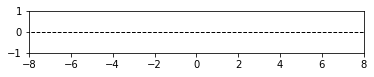

In [11]:
# Set up a new figure, with equal aspect ratio.
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
ax.set_xlim(left=-extent, right=extent)
ax.set_ylim(bottom=-1, top=1)
ax.set_aspect('equal')
ax.axhline(y=0, xmin=-extent, xmax=extent, c="black", linewidth=1, linestyle="--", zorder=0)

We also need to set up plot objects, like lines representing the trajectories and the circles representing the current location of each ball.

In [12]:
# These are the objects we need to keep track of.
lineA, = ax.plot([], [], lw=2, linestyle='dotted', color='blue')
lineB, = ax.plot([], [], lw=2, linestyle='dotted', color='red')
ballA = plt.Circle((x0_A, y0_A), rA, color='blue')
ballB = plt.Circle((x0_B, y0_B), rB, color='red')
v1_text = ax.text(-0.9 * extent, -1.5, '', color='blue')
v2_text = ax.text(0.5 * extent, 1.5, '', color='red')
ax.add_patch(ballA)
ax.add_patch(ballB)
xdata_A, ydata_A = [], []
xdata_B, ydata_B = [], []

Final step is to create the animation. The length of the simulation in time is the interval, and will impact the length of time the animation will take to create.

In [13]:
interval = 1000*dt
ani = animation.FuncAnimation(fig, animate, get_pos, blit=True,
                      interval=interval, repeat=False, save_count=100)
from IPython.display import HTML
HTML(ani.to_html5_video())

In the animation you can see the blue ball, which is initially faster than the red ball, impacting at the centre of the image. After the impact, both red and blue balls travel together at the same velocity. This is because the collusion is completely inelastic.

--

### Completely elastic collision

We'll now repeat the experiment, but this time set $e=1$, meaning that this is a totally elastic collision (no energy is lost when the two objects collide).


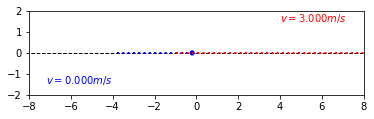

In [14]:
#masses, velocities and e
m_A, u_A = 2.0, 4.0
m_B, u_B = 4.0, 1.0
e = 1.0
rA, rB = 0.1, 0.1
# Initial position and velocity vectors.
vx0_A = u_A 
vx0_B = u_B 
x0_A = -u_A
x0_B = -u_B
lval = (max(abs(x0_A), abs(x0_B)))
extent = 2 * int(math.ceil(lval))
# matrix of coeffs (to use to solve simultaneous equations)
A = [[1, -1], [m_B, m_A]]    
# Set up a new figure, with equal aspect ratio.
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
ax.set_xlim(left=-extent, right=extent)
ax.set_ylim(bottom=-2, top=2)
ax.set_aspect('equal')
ax.axhline(y=0, xmin=-extent, xmax=extent, c="black", linewidth=1, linestyle="--", zorder=0)
    
# These are the objects we need to keep track of.
lineA, = ax.plot([], [], lw=2, linestyle='dotted', color='blue')
lineB, = ax.plot([], [], lw=2, linestyle='dotted', color='red')
ballA = plt.Circle((x0_A, y0_A), rA, color='blue')
ballB = plt.Circle((x0_B, y0_B), rB, color='red')
v1_text = ax.text(-0.9 * extent, -1.5, '', color='blue')
v2_text = ax.text(0.5 * extent, 1.5, '', color='red')
ax.add_patch(ballA)
ax.add_patch(ballB)
xdata_A, ydata_A = [], []
xdata_B, ydata_B = [], []
interval = 1000*dt
ani = animation.FuncAnimation(fig, animate, get_pos, blit=True,
                      interval=interval, repeat=False, save_count=100)
HTML(ani.to_html5_video())

In this example, the balls have identical initial masses and speeds to the previous case, but now $e=1$. This causes the blue ball to stop dead upon impacting the red ball, while the red ball travels much faster after the collision. All the energy of the faster object has been transferred to the slower object by the elasticity of the collision.

--

### 'Real-world' inelastic collisions

In reality, few if any collisions are completely inelastic or completely elastic. Instead the coefficient of restitution is often $0<e<1$. 

To explore this, we'll repeat the animation, selecting $e=0.359$, which is approximately the coefficient of restitution between snooker balls. Snooker balls also have mass $m\approx0.4~{\rm{kg}}$. In this example, we'll explore behaviour when a fast moving snooker ball impacts a stationary ball:


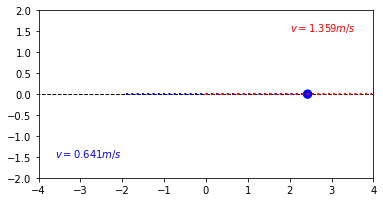

In [15]:
#masses, velocities and e
m_A, u_A = 0.4, 2.0
m_B, u_B = 0.4, 0.0
e = 0.359
rA, rB = 0.1, 0.1
# Initial position and velocity vectors.
vx0_A = u_A 
vx0_B = u_B 
x0_A = -u_A
x0_B = -u_B
lval = (max(abs(x0_A), abs(x0_B)))
extent = 2 * int(math.ceil(lval))
# matrix of coeffs (to use to solve simultaneous equations)
A = [[1, -1], [m_B, m_A]]    
# Set up a new figure, with equal aspect ratio.
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
ax.set_xlim(left=-extent, right=extent)
ax.set_ylim(bottom=-2, top=2)
ax.set_aspect('equal')
ax.axhline(y=0, xmin=-extent, xmax=extent, c="black", linewidth=1, linestyle="--", zorder=0)
    
# These are the objects we need to keep track of.
lineA, = ax.plot([], [], lw=2, linestyle='dotted', color='blue')
lineB, = ax.plot([], [], lw=2, linestyle='dotted', color='red')
ballA = plt.Circle((x0_A, y0_A), rA, color='blue')
ballB = plt.Circle((x0_B, y0_B), rB, color='red')
v1_text = ax.text(-0.9 * extent, -1.5, '', color='blue')
v2_text = ax.text(0.5 * extent, 1.5, '', color='red')
ax.add_patch(ballA)
ax.add_patch(ballB)
xdata_A, ydata_A = [], []
xdata_B, ydata_B = [], []
interval = 1000*dt
ani = animation.FuncAnimation(fig, animate, get_pos, blit=True,
                      interval=interval, repeat=False, save_count=100)
HTML(ani.to_html5_video())

This is a very simple example, and omits a lot of important physics aspects. 

Realistic ball physics depends on many more conditions, including where the ball is struck, and what type of motion is imparted (is there spin? is the surface frictionless? Is there air resistance? Is the table level?). However, every collision model is underpinned by the mathematics demonstrated here.

## Over To You

This worksheet illustrates how to use symbolic Python can solve a set of simultaneous equations for us and animate them.

Try importing some of your tutorial problems into the above animation code.
Can you verify your solutions and the behaviour you recover using the tools shown here?